#Indice

[El modelo](#model)
* [Solver de Roe](#solver)
* [Función de flujo en la interfaz](#flux)
* [Calcular todos los flujos](#interflux)
* [Condición de borde](#bcs)
* [Para determinar $\Delta t$ según CFL](#setdt)
* [Para realizar las iteraciones](#iterate)

[Caso 1: Rompimiento de presa 1D](#case1)
* [Datos](#c1-data)
* [Correr la simulación](#c1-sim)
* [Visualizar perfiles de superficie libre](#c1-vis)
* [Visualizar animación JS](#c1-animjs)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Observación
Falla para $h_r=0$, un problema con que el h sea muy chico en el borde. Esto debería ser demostrable.

<a id="model"> </a>
#El modelo

<a id="solver"> </a>
##Solver de Roe

In [19]:
# %%writefile nswe.py 

import numpy as np
g = 9.81
def roe(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if hl<0 or hr<0:
        print hl,hr
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    return hs,us

<a id="flux"> </a>
##Funcion de flujo en interfaz

In [20]:
# %%writefile nswe.py -a

def flux(h,u):
    """
        h,u escalares, returna F(U)
    """
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

<a id="interflux"></a>
##Calcular los flujos de las interfaces

$f_i$ es el flujo entre la celda $i$ y la $i+1$

In [21]:
# %%writefile nswe.py -a
#rutina anterior q recibe n en vez de nx
def fluxes0(h,hu,n):
    """
        Calcula loos flujos en cada interfaz,
        retorna la matriz de 2xninterfaces
    """
    f = np.zeros((2,nx-1))
    for i in range(nx-1):
        hs,us = roe(h[n,i],hu[n,i],h[n,i+1],hu[n,i+1])
        f[:,i] = flux(hs,us)
    return f

In [22]:
# %%writefile nswe.py -a

def fluxes(h0,hu0,nx):
    """
        Calcula loos flujos en cada interfaz,
        retorna la matriz de 2xninterfaces
    """
    f = np.zeros((2,nx-1))
    for i in range(nx-1):
        hs,us = roe(h0[i],hu0[i],h0[i+1],hu0[i+1])
        f[:,i] = flux(hs,us)
    return f

<a id="bcs"> </a>
##Función para las condiciones de borde

In [23]:
def bcs_cerrado(h,hu,n):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    hb = 1.*h
    hub = 1.*hu
    hb[n,0] = h[n,1]
    hub[n,0] = -hu[n,1]
    hb[n,-1] = h[n,-2]
    hub[n,-1] = -hu[n,-2]    
    return hb,hub

<a id="setdt"></a>
##Función para determinar dt

In [24]:
def setdt(h,hu,n,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)
    s = np.max(np.abs(u_n)+np.sqrt(9.81*h[n,:]))
    dt = cfl*dx/np.max(s)
    return dt

<a id="iterate"></a>
##Funcion para calcular las iteraciones

In [25]:
def simulate(h,hu,bcs,dx,cfl,t0,nt):
    """
        Rutina principal que corre la simulacion
    """
    t = np.zeros((nt,))
    for n in range(nt-1):     
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        h,hu = bcs(h,hu,n)    
        f = fluxes0(h,hu,n)

        h[n+1,1:-1] = h[n,1:-1] -dt/dx*(f[0,1:]-f[0,:-1])
        hu[n+1,1:-1] = hu[n,1:-1] -dt/dx*(f[1,1:]-f[1,:-1])   
        
    return t,h,hu

<a id="case1"></a>
#Caso 1: rompimiento de presa

<a id="c1-data"></a>
##Datos

In [26]:
L = 30.
npoints = 40
dx = L/40
x = np.arange(0,L,dx)
dx = np.min(np.diff(x))
nx = x.shape[0]
cfl = 0.45
t0  = 0.
nt = 100

h = np.zeros((nt,x.shape[0]))
hu = np.zeros((nt,x.shape[0]))
h[0,:] = np.where(x<L/2, 10., 1.)
hu[0,:] = 0.


<a id="c1-sim"></a>
##Simulacion

In [27]:
t,h,hu = simulate(h,hu,bcs_cerrado,dx,cfl,t0,nt)

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


<a id="c1-vis"></a>
##Visualización preliminar

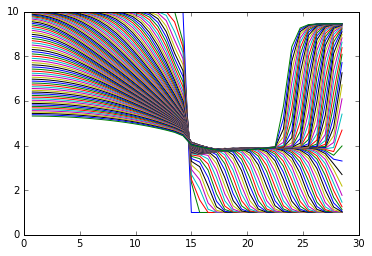

In [28]:
dk = 1
for it in range(0,t.shape[0],dk):
    plt.plot(x[1:-1],h[it,1:-1].T, label='%.2f'%t[it])
# plt.plot(x,np.ones_like(x)*40/9.)
plt.plot([0,10],[0.,0.])
# plt.legend(ncol=2)

<a id="c1-animjs"></a>
##Animación JS

In [29]:
import JSAnimation


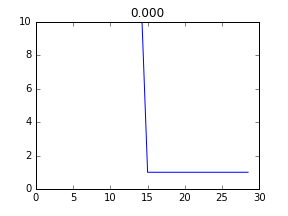
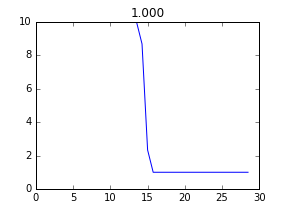
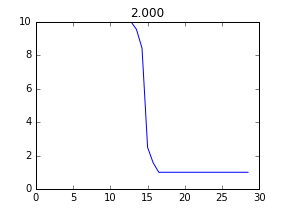
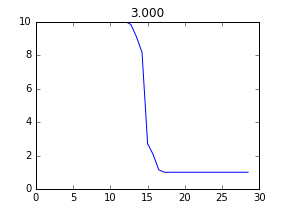
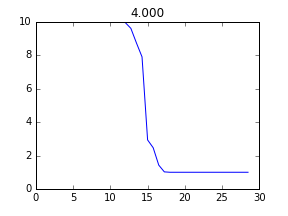
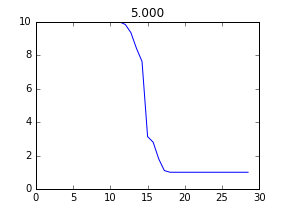
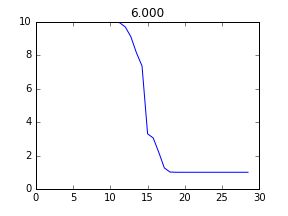
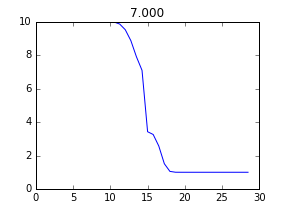
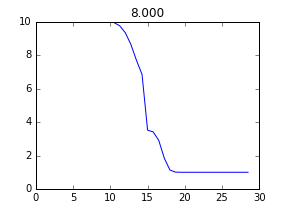
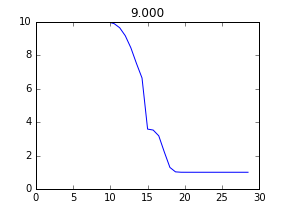
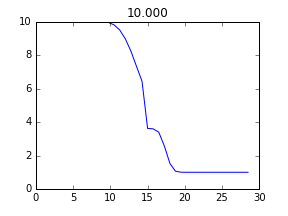
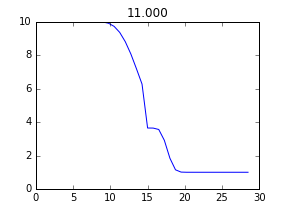
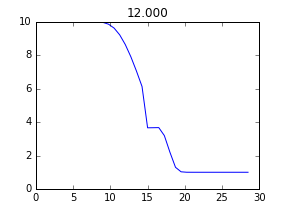
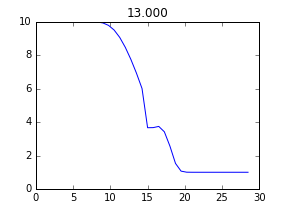
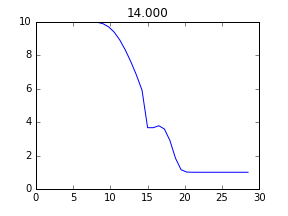
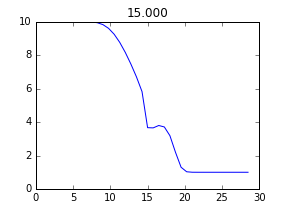
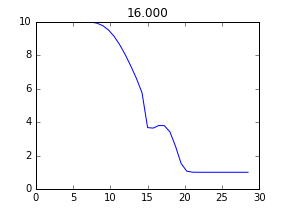
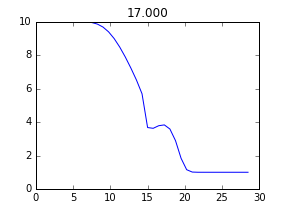
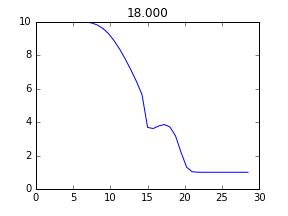
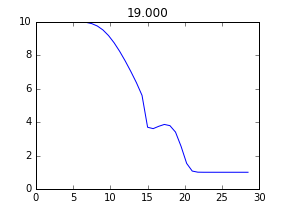
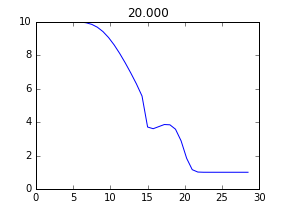
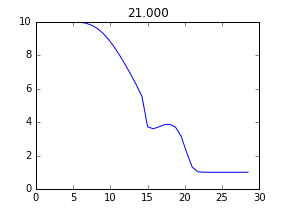
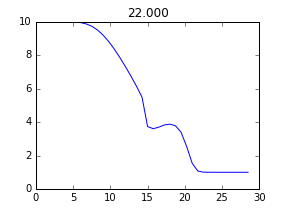
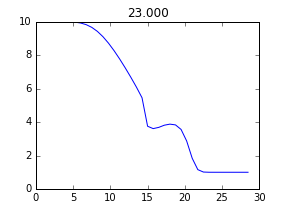
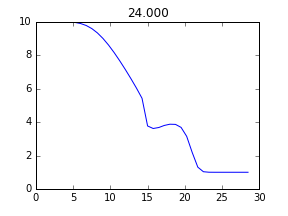
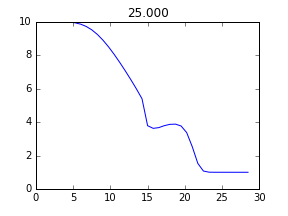
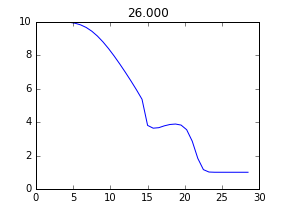
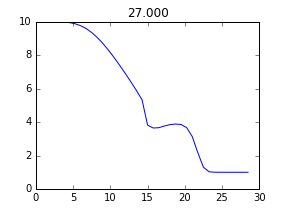
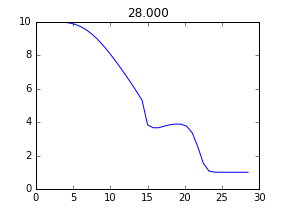
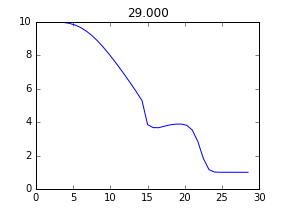
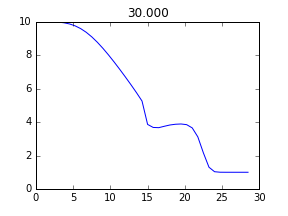
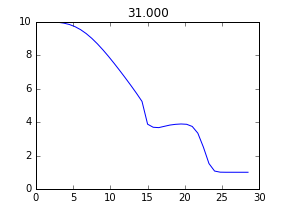
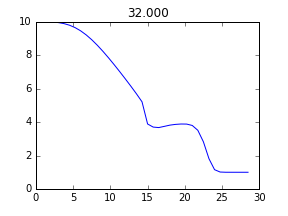
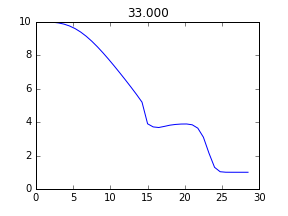
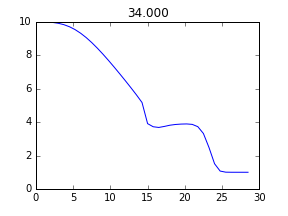
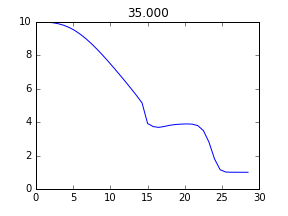
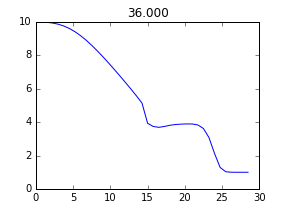
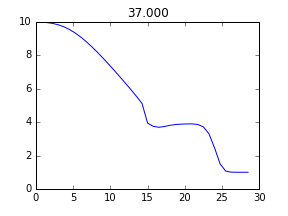
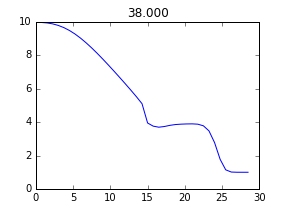
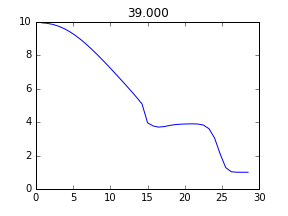
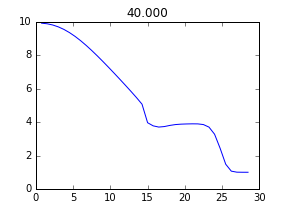
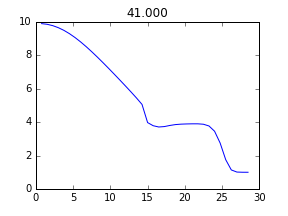
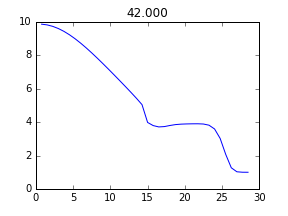
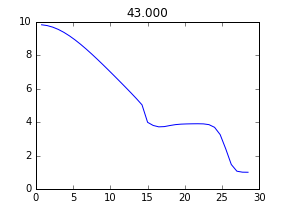
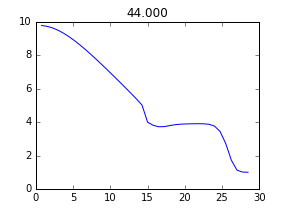
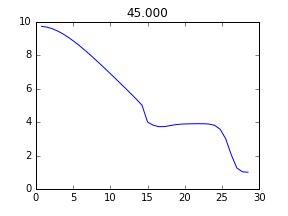
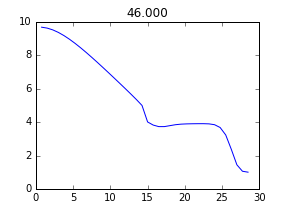
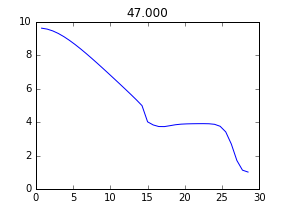
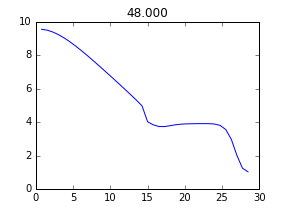
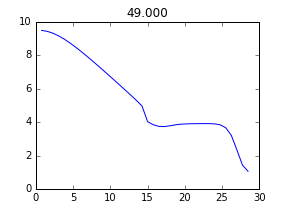
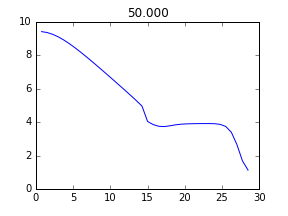
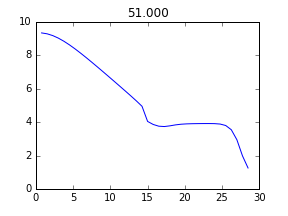
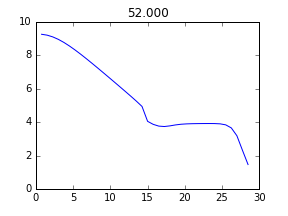
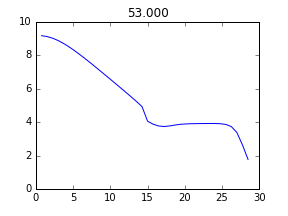
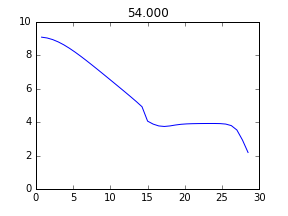
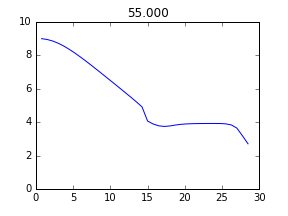
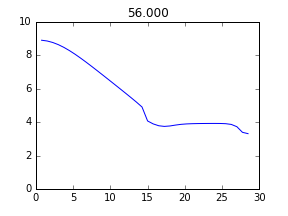
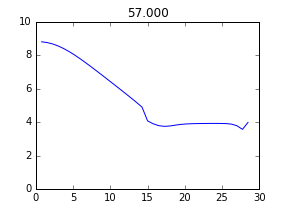
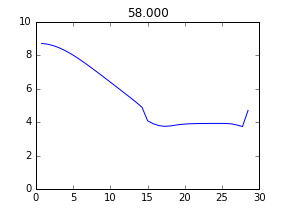
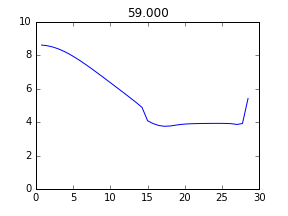
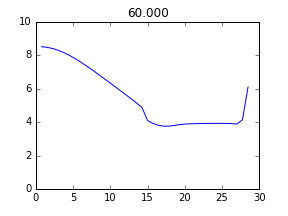
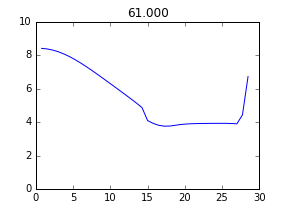
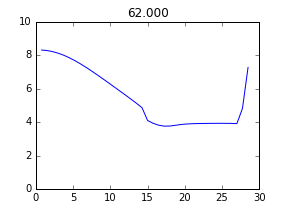
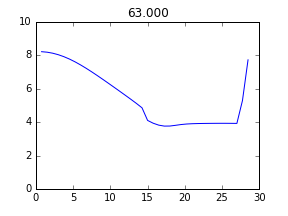
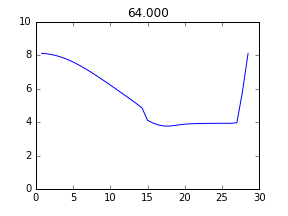
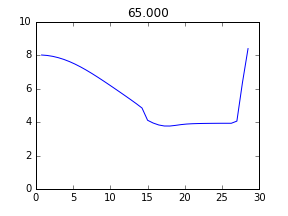
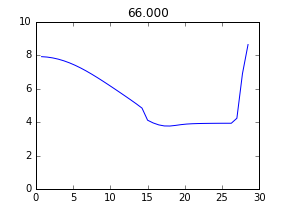
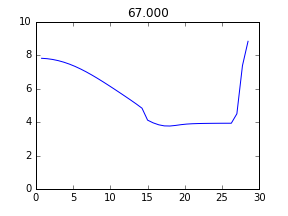
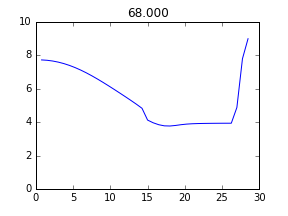
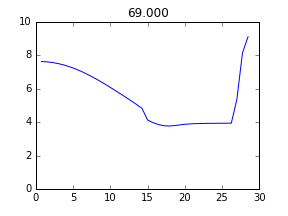
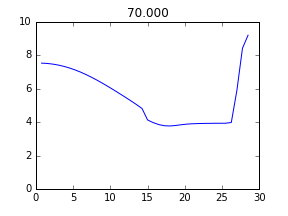
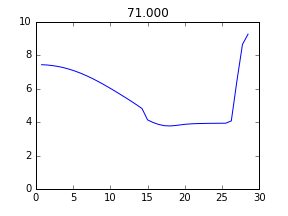
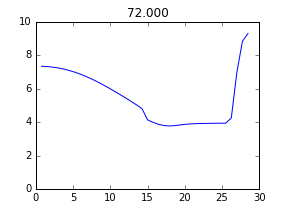
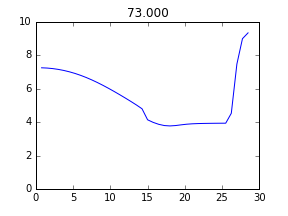
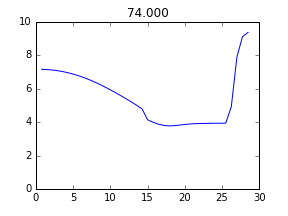
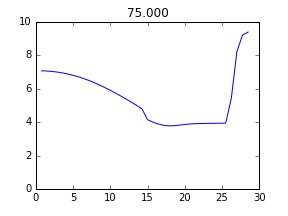
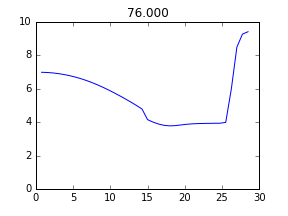
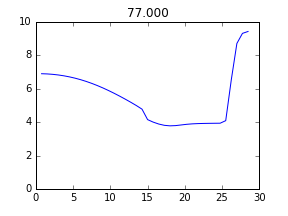
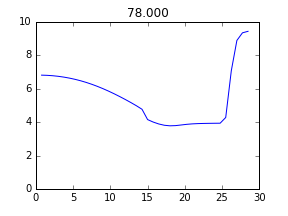
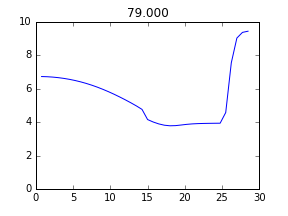
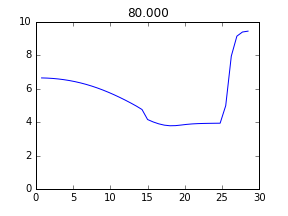
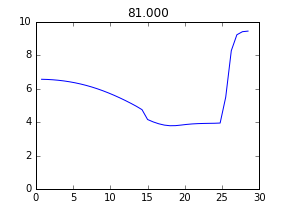
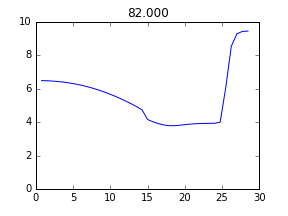
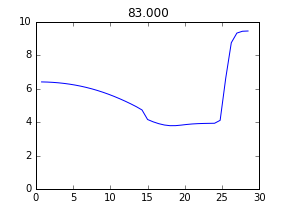
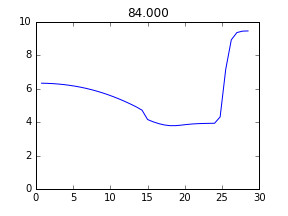
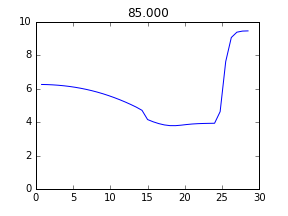
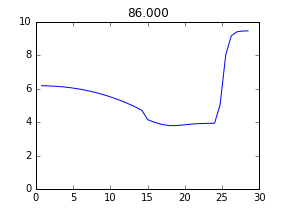
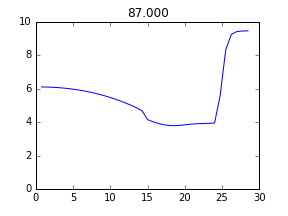
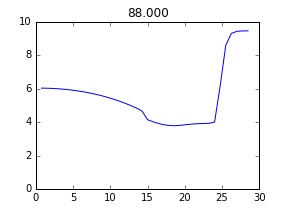
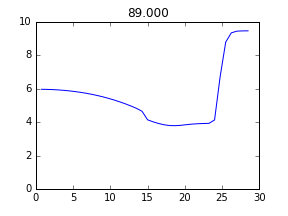
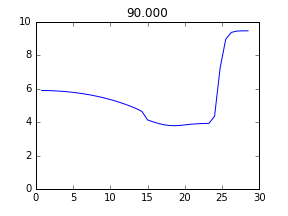
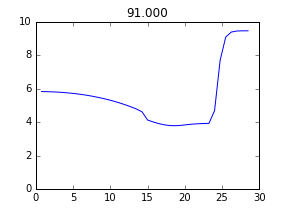
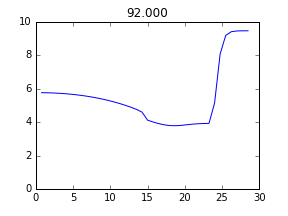
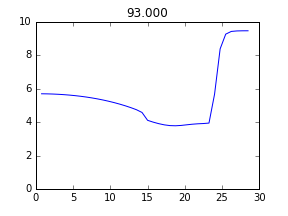
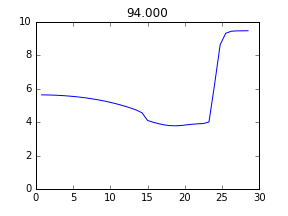
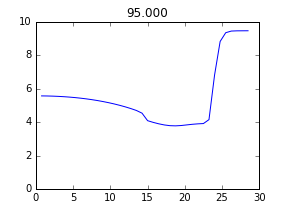
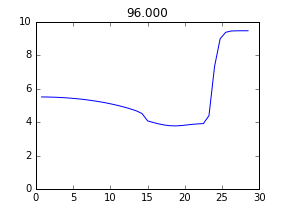
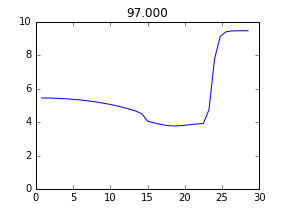
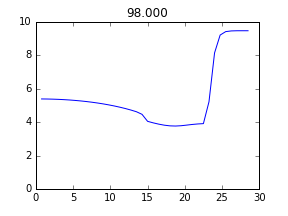
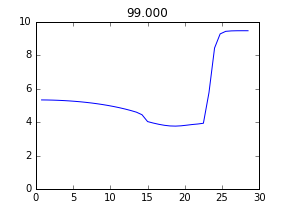

In [30]:
from JSAnimation import IPython_display
from matplotlib import animation
f1 = plt.figure(figsize=(4.,3))
ax1 = f1.add_subplot(111)
lh, = ax1.plot(x[1:-1],h[0,1:-1])
ax1.set_ylim(0,10)

def animate(i):
    i=min(i,h.shape[0]-1)
    lh.set_ydata(h[i,1:-1])
    ax1.set_title('%.3f'%(i))

animation.FuncAnimation(f1,animate,frames=range(nt))